# Trabalho Final Análise de Dados

Script para Rede Neural para classificação do estado do mercado: nervoso ou normal.
mediante a PCA - componente principais das taxas de juros -, taxa de câmbio spot e expectativa do IPCA 12 meses a frente

Alunos: Adriana Bessa, Matheus Quinete e Raphael Castro

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import pandas as pd
import numpy as np
import numpy.random as rd
import scipy.stats
import datetime
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from math import sqrt
from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression

Using TensorFlow backend.


In [2]:
def add_working_days(start_date, added_days, holidays):

    days_elapsed = 0
    while days_elapsed < added_days:
        test_date = start_date + timedelta(days=1)
        start_date = test_date
        if test_date.weekday()>4 or test_date in holidays:
            # if a weekend or holiday, skip
            continue
        else:
            # if a workday, count as a day
            days_elapsed += 1

    return start_date

In [3]:
def count_working_days(start_date, end_date, holidays):

    bdays = 0
    while start_date < end_date:
        test_date = start_date + timedelta(days=1)
        start_date = test_date
        if test_date.weekday()>4 or test_date in holidays:
            # if a weekend or holiday, skip
            continue
        else:
            # if a workday, count as a day
            bdays += 1

    return bdays

In [4]:
def interp_exp(t0,tx,t1,t2,x1,x2,holidays):
    ntx = count_working_days(t0, tx, holidays)
    nt1 = count_working_days(t0, t1, holidays)
    nt2 = count_working_days(t0, t2, holidays)
    
    x = (((((1.+ (x1/100))**(nt1/252))*
        (((1.+ (x2/100))**(nt2/252))/
        ((1.+ (x1/100))**(nt1/252)))
        **((ntx - nt1)/(nt2 - nt1)))**
        (252/(ntx))) -1)*100
    return x

In [5]:
def vol_ewma(series, lmb):
    v = list()
    v.append(abs(series.iloc[0]))
    for i in range(1,len(series)):
        v.append(np.sqrt(lmb*v[-1]*v[-1] + (1-lmb)*series.iloc[i]*series.iloc[i]))
    return v

In [6]:
def z_score_sig(series):
    z_series = (series - (sum(series)/len(series)))/np.std(series)
    sig_series = 1/(1+np.exp(-series))
    return sig_series

In [7]:
# Lendo arquivo Bloomberg

startTime = datetime.now()

file = 'Dados_Bberg.xlsx'
dados = pd.ExcelFile(file)
df = dados.parse('Dados')
feriados = dados.parse('Feriados')
feriados = pd.to_datetime(feriados['Feriados'])
feriados = feriados.tolist()

print(df.head())
print(len(df))

       Datas      IBOV     USD  2000-02-01 00:00:00  2000-03-01 00:00:00  \
0 2000-01-03  16930.42  1.8190               19.105               19.380   
1 2000-01-04  15851.00  1.8510               19.221               19.604   
2 2000-01-05  16245.14  1.8390               19.203               19.494   
3 2000-01-06  16106.89  1.8415               19.138               19.426   
4 2000-01-07  16309.15  1.8270               19.071               19.218   

   2000-04-01 00:00:00  2000-05-01 00:00:00  2000-06-01 00:00:00  \
0               19.695               19.999               20.335   
1               19.985               20.250               20.584   
2               19.813               20.106               20.419   
3               19.705               20.019               20.414   
4               19.459               19.726               20.034   

   2000-07-01 00:00:00  2000-08-01 00:00:00  ...    2030-05-01 00:00:00  \
0               20.633               20.870  ...  #N/A Inva

In [8]:
# Interpolacao

# lista = {'1M':21,'2M':42,'3M':63,'4M':84,'5M':105,'6M':126,'7M':147,'8M':168,'9M':189,
#          '10M':210,'11M':231,'12M':252,'13M':273,'14M':294,'15M':315,'16M':336,'17M':357,'18M':378}
lista = {'1M':21,'3M':63,'6M':126,'9M':189,'12M':252}

df_tenors = pd.DataFrame(0,index=range(0,len(df)),columns=lista.keys())
df_tenors= pd.concat([df.iloc[:,0],df_tenors],axis=1)
df_aux = df_tenors.copy()

for i in range(0,len(df_tenors)):
    print(i)
    for j in range(0,len(lista)):
        t = timedelta(days=list(lista.values())[j])
        df_aux.iloc[i,j+1] = add_working_days(df_tenors.iloc[i,0], int(t.days), feriados)
        
        k = 4
        m = 1
        while df.columns[k-m] <= df_aux.iloc[i,j+1] and k < len(df.columns)-1: 
            if df_aux.iloc[i,j+1] <= df.columns[k]:
                while pd.isnull(df.iloc[i,k]) or df.iloc[i,k]==0:
                    k += 1
                    m += 1
                while pd.isnull(df.iloc[i,k-m]) or df.iloc[i,k]==0:
                    m += 1
                df_tenors.iloc[i,j+1] = interp_exp(df_tenors.iloc[i,0],df_aux.iloc[i,j+1],df.columns[k-m],
                                                   df.columns[k],df.iloc[i,k-m],df.iloc[i,k],feriados)
                k += 1
                m = 1
            else:
                k += 1


print(df_tenors.head())
print(len(df_tenors))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [9]:
# conversao em taxa foward 

df_forward = df_tenors.copy()

for i in range(2,len(df_tenors.columns)):
    if len(str(df_forward.columns[i])) > 2 and len(str(df_forward.columns[i-1]))>2:
        t2 = 21*int(str(df_forward.columns[i])[0:2])
        t1 = 21*int(str(df_forward.columns[i-1])[0:2])
        df_forward.iloc[:,i] = (((1.+ df_tenors.iloc[:,i])**(t2/252))/((1.+ df_tenors.iloc[:,i-1])**(t1/252)))**(252/(t2-t1)) -1
    elif len(str(df_forward.columns[i])) > 2 and len(str(df_forward.columns[i-1]))<=2:
        t2 = 21*int(str(df_forward.columns[i])[0:2])
        t1 = 21*int(str(df_forward.columns[i-1])[0])
        df_forward.iloc[:,i] = (((1.+ df_tenors.iloc[:,i])**(t2/252))/((1.+ df_tenors.iloc[:,i-1])**(t1/252)))**(252/(t2-t1)) -1     
    else:
        t2 = 21*int(str(df_forward.columns[i])[0])
        t1 = 21*int(str(df_forward.columns[i-1])[0])
        df_forward.iloc[:,i] = (((1.+ df_tenors.iloc[:,i])**(t2/252))/((1.+ df_tenors.iloc[:,i-1])**(t1/252)))**(252/(t2-t1)) -1



print(df_forward.head())
print(len(df_forward))
df_fra = pd.concat([df_forward,df.iloc[:,1:3]],axis=1)
print(df_fra.head())
print(len(df_fra))

       Datas         1M         3M         6M         9M        12M
0 2000-01-03  19.105000  20.029069  21.667809  22.721680  23.705126
1 2000-01-04  19.256556  20.415329  21.866514  23.066660  24.119229
2 2000-01-05  19.255736  20.189262  21.690434  23.093660  23.752827
3 2000-01-06  19.214340  20.084257  21.833645  23.103567  23.945889
4 2000-01-07  19.121646  19.765166  21.282352  22.694204  23.701026
4805
       Datas         1M         3M         6M         9M        12M      IBOV  \
0 2000-01-03  19.105000  20.029069  21.667809  22.721680  23.705126  16930.42   
1 2000-01-04  19.256556  20.415329  21.866514  23.066660  24.119229  15851.00   
2 2000-01-05  19.255736  20.189262  21.690434  23.093660  23.752827  16245.14   
3 2000-01-06  19.214340  20.084257  21.833645  23.103567  23.945889  16106.89   
4 2000-01-07  19.121646  19.765166  21.282352  22.694204  23.701026  16309.15   

      USD  
0  1.8190  
1  1.8510  
2  1.8390  
3  1.8415  
4  1.8270  
4805


C:\Users\rapha\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


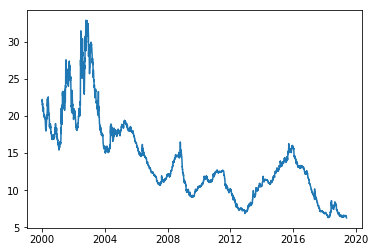

In [10]:
# Grafico DI 12M

df_tenors_graph = df_tenors.copy()
df_tenors_graph.set_index('Datas',inplace=True)     
plt.plot(df_tenors_graph['12M'])
plt.show()

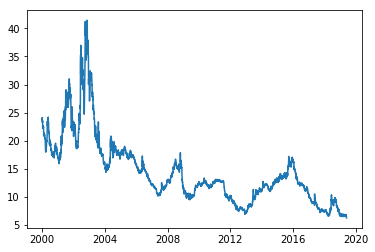

In [11]:
# Grafico FRA DI 12M

df_fra_graph = df_fra.copy()
df_fra_graph.set_index('Datas',inplace=True)     
plt.plot(df_fra_graph['12M'])
plt.show()

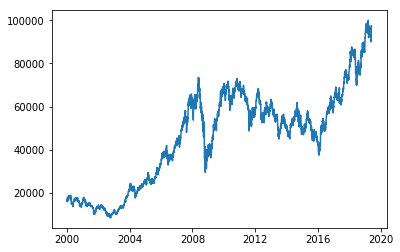

In [12]:
# Grafico IBOV

df_fra_graph = df_fra.copy()
df_fra_graph.set_index('Datas',inplace=True)     
plt.plot(df_fra_graph['IBOV'])
plt.show()

In [13]:
# Lendo o arquivo de Excel

file = 'IPCA.xlsx'
ipca = pd.ExcelFile(file)
ipca = ipca.parse('Sheet1')
print(ipca.head())
print(len(ipca))

       Datas  IPCA
0 2002-01-02  4.68
1 2002-01-03  4.62
2 2002-01-04  4.62
3 2002-01-07  4.58
4 2002-01-08  4.59
4311


In [14]:
# Merge de todos os dados

df_full = df_fra.merge(ipca, on='Datas', how='right')
print(df_full.head())
print(len(df_full))

       Datas         1M         3M         6M         9M        12M      IBOV  \
0 2002-01-02  19.012000  19.022128  19.299683  19.996875  21.417290  13872.09   
1 2002-01-03  18.925214  18.687295  18.964105  19.647239  20.760821  14265.35   
2 2002-01-04  18.955272  18.867928  19.353408  19.958619  21.136311  14331.92   
3 2002-01-07  18.902560  18.774463  19.184717  19.850420  21.327021  14378.59   
4 2002-01-08  18.931583  18.854869  19.259082  20.067472  21.544678  14167.58   

     USD  IPCA  
0  2.302  4.68  
1  2.295  4.62  
2  2.331  4.62  
3  2.327  4.58  
4  2.374  4.59  
4311


In [15]:
# Salva arquivo de Dados de Input e Output

writer = pd.ExcelWriter('Dados Full.xlsx')
df_tenors.to_excel(writer,'Input')
df_full.to_excel(writer,'Output')
writer.save()

In [16]:
# Defasagem para Câmbio e IPCA

df_full['IPCA-1'] = df_full['IPCA'].shift(1)
df_full['USD-1'] = df_full['USD'].shift(1)
df_full = df_full.dropna(how='any').reset_index(drop=True)
print(df_full.head())
print(len(df_full))

datas = df_full['Datas']
datas_ret = df_full.iloc[1:len(df_full),0].reset_index(drop=True)

       Datas         1M         3M         6M         9M        12M      IBOV  \
0 2002-01-03  18.925214  18.687295  18.964105  19.647239  20.760821  14265.35   
1 2002-01-04  18.955272  18.867928  19.353408  19.958619  21.136311  14331.92   
2 2002-01-07  18.902560  18.774463  19.184717  19.850420  21.327021  14378.59   
3 2002-01-08  18.931583  18.854869  19.259082  20.067472  21.544678  14167.58   
4 2002-01-09  18.966061  18.982619  19.444598  20.412011  21.956274  14020.79   

     USD  IPCA  IPCA-1  USD-1  
0  2.295  4.62    4.68  2.302  
1  2.331  4.62    4.62  2.295  
2  2.327  4.58    4.62  2.331  
3  2.374  4.59    4.58  2.327  
4  2.375  4.59    4.59  2.374  
4310


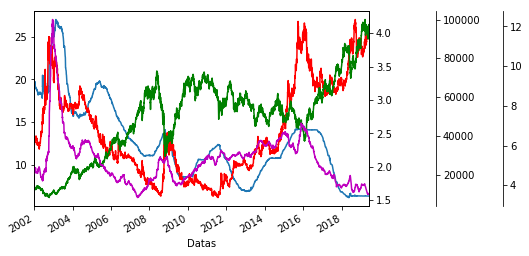

In [17]:
# Grafico todas variaveis

df_full_graph = df_full.copy()
df_full_graph.set_index('Datas',inplace=True)     
ax1 = df_full_graph['1M'].plot()

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_full_graph['USD'].plot(ax=ax2,color='r')
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
df_full_graph['IBOV'].plot(ax=ax3,color='g')
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('axes', 1.4))
df_full_graph['IPCA'].plot(ax=ax4,color='m')
plt.show()

## 1 - Principal Component Analysis (PCA)

https://www.moodysanalytics.com/-/media/whitepaper/2014/2014-29-08-pca-for-yield-curve-modelling.pdf

Um componente principal (CP) é um vetor, com uma entrada para cada variável do problema em questão.

Mudança de base de modo que os novos vetores expliquem a maior parte da variância. Naturalmente, isto pressupõe que a informação relevante do sistema está contida na variância.

1. Via matriz de covariância
2. Via decomposição SVD

In [18]:
# Normalizacao

df_scaled = StandardScaler().fit_transform(df_full.iloc[:,1:len(df_full.columns)-5])
print(df_scaled[0:5,:])
print(len(df_scaled))

[[1.33217819 1.22808204 1.1745801  1.19165477 1.26861934]
 [1.33869578 1.2660621  1.25174776 1.2498623  1.33515631]
 [1.32726602 1.24640999 1.21830985 1.22963628 1.36895023]
 [1.3335591  1.26331637 1.23305051 1.27021057 1.40751924]
 [1.34103506 1.2901772  1.26982354 1.33461653 1.4804542 ]]
4310


In [19]:
# Fazendo o PCA

N = 3
## Só considera as 3 principais componentes

pca = PCA(n_components=N,svd_solver='arpack')

pc = pca.fit(df_scaled) # Fit do PCA
pc_transform = pca.fit_transform(df_scaled) # Fit do PCA, e aplica o modelo nos dados, reduzindo sua dimensionalidade

var = pca.explained_variance_ratio_

print(var)
print()

# Autovalores

eigenvalues = pca.singular_values_

print(eigenvalues)  
print()

# Autovetores

eigenvectors = pca.components_

for i in range(0,len(eigenvectors)):
    print("Autovetor "+str(i+1))
    print(eigenvectors[i])
    print()
    
print('Componente 1: '+ "%.1f%%" % (var[0]*100))
print('Componente 2: '+ "%.1f%%" % (var[1]*100))
print('Componente 3: '+ "%.1f%%" % (var[2]*100))
print('Acumulado   : '+ "%.1f%%" % ((var[0]+var[1]+var[2])*100))

[0.95692274 0.04078444 0.00182365]

[143.60252418  29.64632651   6.26894863]

Autovetor 1
[0.43686471 0.45073544 0.45589292 0.45047423 0.44183866]

Autovetor 2
[-0.64565356 -0.36337244  0.07318277  0.37171235  0.55458648]

Autovetor 3
[ 0.40789727 -0.12810701 -0.68264392 -0.14108961  0.57558614]

Componente 1: 95.7%
Componente 2: 4.1%
Componente 3: 0.2%
Acumulado   : 100.0%


            Componente 1  Componente 2  Componente 3
Datas                                               
2002-01-03      2.768339     -0.073906      0.146316
2002-01-04      2.879105     -0.027731      0.121516
2002-01-07      2.855830     -0.004433      0.164502
2002-01-08      2.908239      0.022911      0.171316
2002-01-09      3.001615      0.075404      0.178715
4310


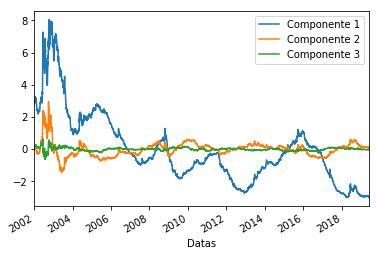

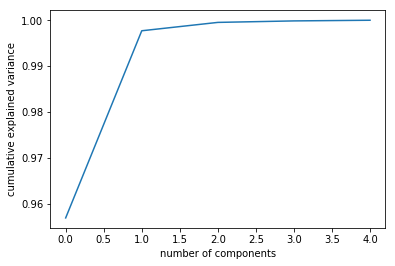

In [20]:
# Componentes Principais
    
col = []
for i in range(0,N):
    col.append('Componente '+str(i+1))

df_pc = pd.DataFrame(data = pc_transform, columns = col)
df_pc_graph = df_pc.copy()
df_pc_graph = pd.concat([datas, df_pc_graph], axis = 1)
df_pc_graph.set_index('Datas',inplace=True)    
print(df_pc_graph.head())
print(len(df_pc_graph))

df_pc_graph.plot()
plt.show()

pca = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [21]:
# Colocando dados de cambio e Ibov, na diferença (diferença do log-retorno). Considerando o cambio e o ipca defasados

ibov = df_full["IBOV"]
ibov_ret = pd.Series(np.log(ibov).diff().dropna(how='any',axis=0).reset_index(drop=True))
cambio = df_full["USD-1"]
cambio_ret = pd.Series(np.log(cambio).diff().dropna(how='any',axis=0).reset_index(drop=True))
ipca = (df_full["IPCA-1"]/100+1) ## ipca é uma taxa vezes 100, precisa transformar em fator

ipca_ret = pd.Series(ipca.iloc[1:len(ipca)]).dropna(how='any',axis=0).reset_index(drop=True)

print(len(ibov_ret))
print(len(cambio_ret))
print(len(ipca_ret))

4309
4309
4309


            VOL IBOV
Datas               
2002-01-04  0.004656
2002-01-07  0.004584
2002-01-08  0.005733
2002-01-09  0.006115
2002-01-10  0.009959
4309


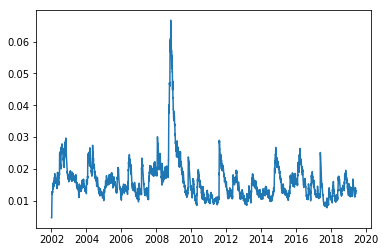

In [22]:
# Cálculo da Volatilidade: 
# Critério Escolido EWMA (varânica da dif do log-retorno do ibov com fator de decaimentoe 0,94)


a = vol_ewma(ibov_ret,0.94)
df_vol = pd.DataFrame(a)
df_vol_graph = df_vol.copy()
df_vol_graph = pd.concat([datas_ret, df_vol_graph], axis = 1)
df_vol_graph.set_index('Datas',inplace=True)   
df_vol_graph.columns = ['VOL IBOV']

print(df_vol_graph.head())
print(len(df_vol_graph))

plt.plot(df_vol_graph)
plt.show()

,0
count,4309.000000
mean,0.016022
std,0.006318
min,0.004584
25%,0.012189
50%,0.014590
75%,0.018014
max,0.066689


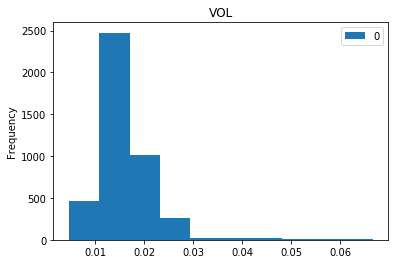

In [23]:
# visualização dos dados

df_vol.plot(kind='hist')
plt.title('VOL')

df_vol.describe()

In [24]:
# aplicação da Zscore

df_voln = z_score_sig(df_vol)
df_voln.columns = ['VOL']
df_cambion = pd.DataFrame(z_score_sig(cambio_ret))
df_cambion.columns = ['CAMBIO']
df_ipcan = pd.DataFrame(z_score_sig(ipca_ret))
df_ipcan.columns = ['IPCA']


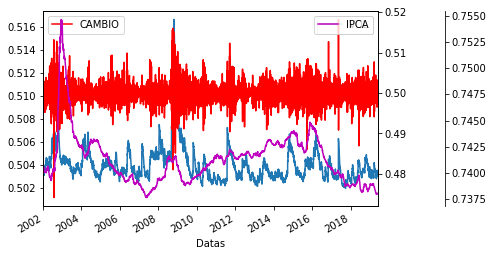

In [25]:
# Gráfico geral das variáveis

df_voln_graph = df_voln.copy()
df_voln_graph = pd.concat([datas, df_voln_graph], axis = 1)
df_voln_graph.set_index('Datas',inplace=True) 
df_cambion_graph = df_cambion.copy()
df_cambion_graph = pd.concat([datas, df_cambion_graph], axis = 1)
df_cambion_graph.set_index('Datas',inplace=True) 
df_ipcan_graph = df_ipcan.copy()
df_ipcan_graph = pd.concat([datas, df_ipcan_graph], axis = 1)
df_ipcan_graph.set_index('Datas',inplace=True)  

ax1 = df_voln_graph.plot()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_cambion_graph.plot(ax=ax2,color='r')
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
df_ipcan_graph.plot(ax=ax3,color='m')
plt.show()


               VOL
count  4309.000000
mean      0.504005
std       0.001579
min       0.501146
25%       0.503047
50%       0.503647
75%       0.504503
max       0.516666


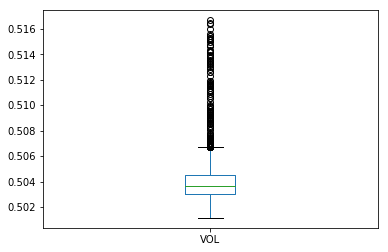

In [26]:
# Estatísticas básicas da Volatilidade normalizada e boxplot
print(df_voln.describe())
df_voln.plot(kind='box')

In [27]:
# Concatenando
df_pc = df_pc.iloc[1:len(df_pc),:].dropna(how='any',axis=0).reset_index(drop=True)

print(len(df_voln))
print(len(df_pc))
print(len(df_cambion))
print(len(df_ipcan))
dados = pd.concat([df_voln,df_pc,df_cambion,df_ipcan],axis=1).dropna(how='any',axis=0).reset_index(drop=True)
print(dados.head())
print(len(dados))

4309
4309
4309
4309
        VOL  Componente 1  Componente 2  Componente 3    CAMBIO      IPCA
0  0.501164      2.879105     -0.027731      0.121516  0.499239  0.740045
1  0.501146      2.855830     -0.004433      0.164502  0.503891  0.740045
2  0.501433      2.908239      0.022911      0.171316  0.499571  0.739968
3  0.501529      3.001615      0.075404      0.178715  0.504999  0.739987
4  0.502490      3.126854      0.144335      0.167257  0.500105  0.739987
4309


In [28]:
# estatísticas básicas de todas as séries
dados.describe()

,VOL,Componente 1,Componente 2,Componente 3,CAMBIO,IPCA
count,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000
mean,0.504005,-0.000642,0.000017,-0.000034,0.500032,0.741293
std,0.001579,2.187477,0.451681,0.095486,0.002732,0.002425
min,0.501146,-3.002562,-1.420683,-0.639248,0.474164,0.737652
25%,0.503047,-1.420183,-0.268695,-0.055373,0.498611,0.739563
50%,0.503647,-0.433526,0.026942,-0.000843,0.499971,0.741293
75%,0.504503,0.978865,0.196458,0.048830,0.501372,0.742519
max,0.516666,8.058351,2.951209,0.640815,0.518166,0.754637


In [29]:
# Definição de amostra Treino e amostra Teste

lim = round(len(dados)*0.8)
n = len(dados.columns)

print(lim)
print(n)

X_train = np.matrix(dados.iloc[0:lim,1:n+1])
Y_train = np.array(dados.iloc[0:lim,0])
print(X_train.shape)

X_pred = np.matrix(dados.iloc[lim:len(dados),1:n+1]) ### X_pred está com 6 colunas
Y_pred = np.array(dados.iloc[lim:len(dados),0])

print(X_train[0:5,])
print(Y_train[0:5,])


3447
6
(3447, 5)
[[ 2.87910538 -0.02773051  0.12151581  0.49923863  0.74004453]
 [ 2.85583027 -0.0044335   0.16450239  0.50389105  0.74004453]
 [ 2.90823891  0.02291062  0.17131605  0.49957063  0.73996757]
 [ 3.0016153   0.07540364  0.17871487  0.50499894  0.73998681]
 [ 3.12685389  0.1443355   0.16725717  0.50010529  0.73998681]]
[0.50116392 0.50114589 0.50143315 0.50152887 0.50248972]


In [30]:
# Script Rede Keras da aula

from keras import optimizers
np.random.seed(7)
model = Sequential()
model.add(Dense(13, input_dim=n-1, activation='sigmoid'))
#model.add(Dense(20, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
adam = optimizers.adam(lr=0.0001)

model.fit(X_train,Y_train, epochs=300, verbose=0)

a = model.evaluate(X_pred,Y_pred)
print(a)
b = model.predict(X_train)
c = model.predict(X_pred)
print(a)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
862/862 [==============================] - 0s 36us/step
1.5596126714730135e-06
1.5596126714730135e-06


In [31]:
# Avaliando
r2train = r2_score((Y_train),(b))
rmsetrain = sqrt(mean_squared_error(Y_train,b))
r2test = r2_score((Y_pred),(c))
rmsetest = sqrt(mean_squared_error(Y_pred,c))
print('Train Rmse:%.5f' % rmsetrain)
print('Train R2:%.3f' % r2train)
print('Test Rmse:%.5f' % rmsetest)
print('Test R2:%.3f' % r2test)

Train Rmse:0.00162
Train R2:0.077
Test Rmse:0.00125
Test R2:-1.041


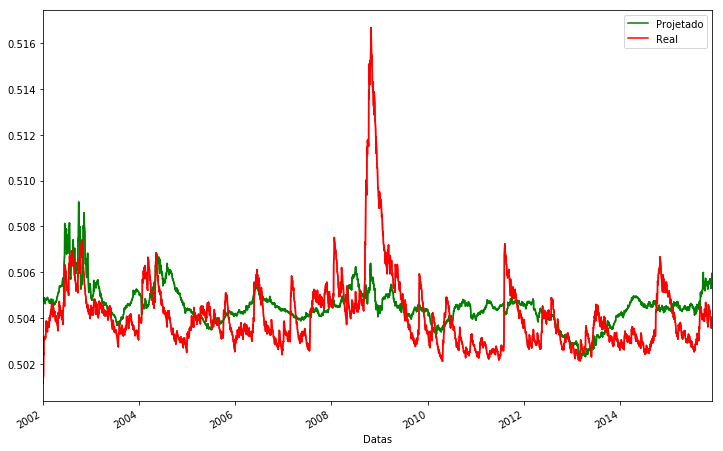

In [32]:
# Gráfico Treino
y = pd.DataFrame(Y_train)
b = pd.DataFrame(b)
dftrain = pd.concat([b,y],axis=1)
dfDatas =df_full[["Datas"]]
dfDataTrain = dfDatas.iloc[0:lim,:].reset_index(drop=True)
dftrain = pd.concat([dfDataTrain,b,y],axis=1)
dftrain.columns = ["Datas",'Projetado','Real']
dftrain1 = dftrain.set_index('Datas', inplace=True)

plot_cols = ['Projetado','Real']
fig,axes = plt.subplots(1,1,figsize=(12,8),sharex=True)
dftrain[plot_cols].plot(ax=axes,color=['g','r'])
dftrain['Projetado'].plot(color='g')
dftrain['Real'].plot(color='r')
plt.show()

In [33]:
# Estatísticas dos Resultados de Treino

dfftrain = pd.concat([b,y],axis=1)
a = ((y-b)**2)
print('Desvio Médio', a.mean())
dfftrain = pd.concat([dfftrain,a],axis=1)
dfftrain.columns = ['Vol','Vol_pred',"Desvio"]
dfftrain.describe()

Desvio Médio 0    0.000003
dtype: float64


,Vol,Vol_pred,Desvio
count,3447.000000,3447.000000,3.447000e+03
mean,0.504516,0.504136,2.622614e-06
std,0.000821,0.001686,9.025418e-06
min,0.502258,0.501146,4.617579e-13
25%,0.504118,0.503109,2.260662e-07
50%,0.504466,0.503772,9.192829e-07
75%,0.504809,0.504635,2.212405e-06
max,0.509066,0.516666,1.168748e-04


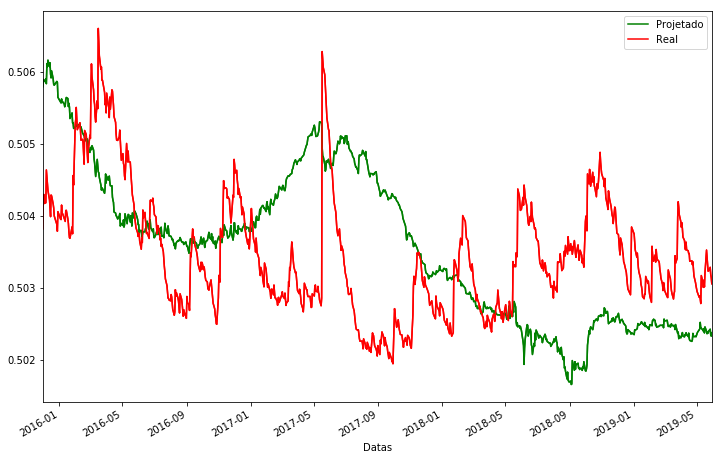

In [34]:
# Gráfico Teste

y = pd.DataFrame(Y_pred)
c = pd.DataFrame(c)
dftest = pd.concat([c,y],axis=1)

dfDataTest = dfDatas.iloc[lim:len(dfDatas),:].reset_index(drop=True)
dftest = pd.concat([dfDataTest,c,y],axis=1)
dftest.columns = ["Datas",'Projetado','Real']
dfttest = dftest.set_index('Datas', inplace=True)


dftest.columns = ['Projetado','Real']

plot_cols = ['Projetado','Real']
fig,axes = plt.subplots(1,1,figsize=(12,8),sharex=True)
dftest[plot_cols].plot(ax=axes,color=['g','r'])
dftest['Projetado'].plot(color='g')
dftest['Real'].plot(color='r')
plt.show()



In [35]:
# Estatísticas dos Resultados de Teste

dfftest = pd.concat([c,y],axis=1)
a =((y-c)**2)
print('Devio Médio', a.mean())
dfftest = pd.concat([dfftest,a],axis=1)
dfftest.columns = ['Vol','Vol_pred',"Desvio"]
dfftest.describe()

Devio Médio 0    0.000002
dtype: float64


,Vol,Vol_pred,Desvio
count,862.000000,862.000000,8.620000e+02
mean,0.503567,0.503485,1.559614e-06
std,0.001054,0.000875,1.694796e-06
min,0.501656,0.501945,6.159746e-12
25%,0.502539,0.502869,1.906233e-07
50%,0.503666,0.503342,8.679401e-07
75%,0.504358,0.503978,2.532543e-06
max,0.506165,0.506606,7.547361e-06


In [36]:
# Cálculo para classificação: transformação de númerico para classes, em torno da média de cada série

mediatrain = dfftrain["Vol"].mean()
mediapredtrain = dfftrain["Vol_pred"].mean()
sdtrain = dfftrain["Vol"].std()
sdptrain = dfftrain["Vol_pred"].std()

mediatest = dfftest["Vol"].mean()
mediapredtest = dfftest["Vol_pred"].mean()
sdtest = dfftest["Vol"].std()
sdptest = dfftest["Vol_pred"].std()

In [37]:
# classificação dos resultados do período teste se estão acima de 1, estão acima da respectiva média ou "normalidade"
# o mesmo é colocado para o y previsto, porque tem média "ou normalidade" diferente do nível do real
# CONSIDERANDO A PREDICAO ANTERIOR

dfAtrain = pd.DataFrame(0,index=range(0,len(dfftrain)),columns=['A'])

for i in range(0,len(dfAtrain)):
    if (dfftrain['Vol'].iloc[i] >= mediatrain+1.5*sdtrain): 
        dfAtrain.iloc[i,0] = 1.0
    else:
        dfAtrain.iloc[i,0] = 0   
dfBtrain = pd.DataFrame(0,index=range(0,len(dfftrain)),columns=['B'])

for i in range(0,len(dfBtrain)):
    if (dfftrain['Vol_pred'].iloc[i]  >= mediapredtrain+1.5*sdtrain):
        dfBtrain.iloc[i,0] = 1.0
    else:
        dfBtrain.iloc[i,0] = 0

dfAtest = pd.DataFrame(0,index=range(0,len(dfftest)),columns=['A'])

for i in range(0,len(dfAtest)):
    if (dfftest['Vol'].iloc[i] >= mediatest+1.5*sdtest): 
        dfAtest.iloc[i,0] = 1.0
    else:
        dfAtest.iloc[i,0] = 0   
dfBtest = pd.DataFrame(0,index=range(0,len(dfftest)),columns=['B'])

for i in range(0,len(dfBtest)):
    if (dfftest['Vol_pred'].iloc[i]  >= mediapredtest+1.5*sdptest):
        dfBtest.iloc[i,0] = 1.0
    else:
        dfBtest.iloc[i,0] = 0

Resultados

In [38]:
# Taxas de erro

erro_train = sum((dfAtrain['A']-dfBtrain["B"])**2)/len(dfAtrain)
print("Taxa de erro train de classificação",erro_train*100)
erro_test = sum((dfAtest['A']-dfBtest["B"])**2)/len(dfAtest)
print("Taxa de erro test de classificação",erro_test*100)

Taxa de erro train de classificação 14.331302581955324
Taxa de erro test de classificação 13.225058004640372


In [39]:
#MMatriz Confusão SkLearn

actual = dfAtrain.iloc[:,0]
predicted = dfBtrain.iloc[:,0]
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix Train :')
print(results) 
accuracy_score(actual, predicted) 
print (classification_report(actual, predicted))

actual = dfAtest.iloc[:,0]
predicted = dfBtest.iloc[:,0]
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix Test :')
print(results) 
accuracy_score(actual, predicted) 
print (classification_report(actual, predicted))
print(recall_score(actual,predicted,average='weighted'))
    

Confusion Matrix Train :
[[2847  367]
 [ 127  106]]
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      3214
         1.0       0.22      0.45      0.30       233

   micro avg       0.86      0.86      0.86      3447
   macro avg       0.59      0.67      0.61      3447
weighted avg       0.91      0.86      0.88      3447

Confusion Matrix Test :
[[739  66]
 [ 48   9]]
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       805
         1.0       0.12      0.16      0.14        57

   micro avg       0.87      0.87      0.87       862
   macro avg       0.53      0.54      0.53       862
weighted avg       0.88      0.87      0.88       862

0.8677494199535963


In [40]:
# classifica os resultados do componente principal 1, para comparar com a vol classificada
# para ver se o componente principal 1 classifica melhor que rede no período de teste

X_pred = pd.DataFrame(X_pred)
comp1 = X_pred.iloc[:,0]/X_pred.iloc[:,0].mean()

dfC = pd.DataFrame(0,index=range(0,len(comp1)),columns=['C'])

for i in range(0,len(dfC)):
    if comp1.iloc[i] >= 1:
        dfC.iloc[i,0] = 1.0
    else:
        dfC.iloc[i,0] = 0

a=sum((dfAtest['A']-dfC["C"])**2)/len(dfAtest)
print("Taxa de erro de classificação",a*100)


Taxa de erro de classificação 63.80510440835266


# Backtest

In [41]:
print(len(dados))
dados.head()


4309


,VOL,Componente 1,Componente 2,Componente 3,CAMBIO,IPCA
0,0.501164,2.879105,-0.027731,0.121516,0.499239,0.740045
1,0.501146,2.855830,-0.004433,0.164502,0.503891,0.740045
2,0.501433,2.908239,0.022911,0.171316,0.499571,0.739968
3,0.501529,3.001615,0.075404,0.178715,0.504999,0.739987
4,0.502490,3.126854,0.144335,0.167257,0.500105,0.739987


In [42]:
# O objetivo é construir a janela de 1000 treinando com diferentes tamanhos de forecast.

window = 1000
lista_forecast = [100,200,300,400,500]

for forecast in lista_forecast:
    np.random.seed(7)
    model = Sequential()
    model.add(Dense(13, input_dim=n-1, activation='sigmoid'))
    #model.add(Dense(20, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    adam = optimizers.adam(lr=0.0001)
    erro = list()
    precisao = list()
    recall = list()
    f1 = list()
    for i in range(window,len(dados),forecast):
       
        train = dados.iloc[i-window:i-forecast,:]
        pred = dados.iloc[i-forecast:i,:]

        X_train = np.matrix(train.iloc[:,1:n+1])
        Y_train = np.array(train.iloc[:,0])

        X_pred = np.matrix(pred.iloc[:,1:n+1])
        Y_pred = np.array(pred.iloc[:,0])
        model.fit(X_train,Y_train, epochs=50, verbose=0)

        y = pd.DataFrame(Y_pred)
        c = pd.DataFrame(c)
        dftest = pd.concat([c,y],axis=1)
        dftest.columns = ['Vol','Vol_pred']
        media = dftest["Vol"].mean()
        mediapred = dftest["Vol_pred"].mean()
        sd = dftest["Vol"].std()
        sdp = dftest["Vol_pred"].std()

        dfAtest = pd.DataFrame(0,index=range(0,len(dftest)),columns=['A'])

        for i in range(0,len(dfAtest)):
            if (dftest['Vol'].iloc[i] >= media+1.5*sd): 
                dfAtest.iloc[i,0] = 1.0
            else:
                dfAtest.iloc[i,0] = 0   
        dfBtest = pd.DataFrame(0,index=range(0,len(dftest)),columns=['B'])

        for i in range(0,len(dfBtest)):
            if (dftest['Vol_pred'].iloc[i]  >= mediapred+1.5*sdp):
                dfBtest.iloc[i,0] = 1.0
            else:
                dfBtest.iloc[i,0] = 0

        a = (sum((dfAtest['A']-dfBtest["B"])**2)/len(dfAtest))*100
        actual = dfAtest.iloc[:,0]
        predicted = dfBtest.iloc[:,0]
        m_pc = precision_score(actual,predicted,average='weighted')
        m_re = recall_score(actual,predicted,average='weighted')
        m_f1 = f1_score(actual,predicted,average='weighted')
        erro.append(a)
        precisao.append(m_pc)
        recall.append(m_re)
        f1.append(m_f1)
        
    ## Resultados Backtest

    erro = pd.Series(erro)
    precisao = pd.Series(precisao)
    recall = pd.Series(recall)
    f1 = pd.Series(f1)
    desvp = pd.DataFrame([erro.std(),precisao.std()*100,recall.std()*100,f1.std()*100])
    medp = pd.DataFrame([erro.mean(),precisao.mean()*100,recall.mean()*100,f1.mean()*100])
    vari = pd.DataFrame(['Erro','Precisão', 'Recall', 'F-1 Score'])
    tab = pd.concat([vari,desvp,medp],axis=1)
    tab.columns = ["Resultados Backtest","Desvio Padrão","Média"]
    print(forecast)
    print(tab.head())
    print()



100
  Resultados Backtest  Desvio Padrão      Média
0                Erro       1.183518   6.813839
1            Precisão       3.578565  90.702464
2              Recall       1.183518  93.186161
3           F-1 Score       1.466418  90.922766

200
  Resultados Backtest  Desvio Padrão      Média
0                Erro       2.280241   7.690733
1            Precisão       3.998142  89.739944
2              Recall       2.280241  92.309267
3           F-1 Score       2.638758  90.645914

300
  Resultados Backtest  Desvio Padrão      Média
0                Erro       1.282756   9.638438
1            Precisão       1.258405  87.652558
2              Recall       1.282756  90.361562
3           F-1 Score       1.128351  88.941654

400
  Resultados Backtest  Desvio Padrão      Média
0                Erro       3.788107   8.855375
1            Precisão       4.036317  90.182215
2              Recall       3.788107  91.144625
3           F-1 Score       3.779204  90.543437

500
  Resultados Bac

In [43]:
print (datetime.now() - startTime)

0:12:10.283943
